**Inspired by the [first-place solution](https://www.kaggle.com/competitions/image-matching-challenge-2025/discussion/583058) by [@ns6464](https://www.kaggle.com/ns6464), I've put together a demo showcasing how to run MASt3R within Kaggle.**

In [1]:
import sys

In [2]:
class CONFIG:
    # DEBUG Settings
    DRY_RUN = False
    DRY_RUN_MAX_IMAGES = 10

    # Pipeline settings
    NUM_CORES = 2
    MAST3R_MIN_PAIR = 15

In [3]:
!pip install --no-index /kaggle/input/imc2024-packages-lightglue-rerun-kornia/* --no-deps

Processing /kaggle/input/imc2024-packages-lightglue-rerun-kornia/kornia-0.7.2-py2.py3-none-any.whl
Processing /kaggle/input/imc2024-packages-lightglue-rerun-kornia/kornia_moons-0.2.9-py3-none-any.whl
ERROR: kornia_rs-0.1.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl is not a supported wheel on this platform.


In [4]:
!pip install torch torchvision torchaudio --no-index --find-links=/kaggle/input/mast3r-fix/mast3r-wheels

Looking in links: /kaggle/input/mast3r-fix/mast3r-wheels


In [5]:
!pip install faiss-gpu-cu12 --no-index --find-links=/kaggle/input/mast3r-fix/mast3r-wheels

Looking in links: /kaggle/input/mast3r-fix/mast3r-wheels


In [6]:
# 离线安装所有依赖（不联网）
!pip install --no-index --find-links=/kaggle/input/mast3r-fix/mast3r-wheels \
    -r /kaggle/input/mast3r-fix/mast3r/requirements.txt \
    -r /kaggle/input/mast3r-fix/mast3r/dust3r/requirements.txt \
    -r /kaggle/input/mast3r-fix/mast3r/dust3r/requirements_optional.txt

Looking in links: /kaggle/input/mast3r-fix/mast3r-wheels


In [7]:
# 加入源码主目录（包含 mast3r, dust3r 等子目录）
sys.path.insert(0, "/kaggle/input/mast3r-fix/mast3r")
sys.path.insert(0, '/kaggle/input/mast3r-fix/mast3r/asmk')
sys.path.insert(0, '/kaggle/input/mast3r-fix/mast3r/dust3r/croco/models/curope')

# Run gradio demo with internet on mode:

> !PYTHONPATH="/kaggle/input/mast3r-fix/mast3r/asmk:$PYTHONPATH" python3 /kaggle/input/mast3r-fix/mast3r/demo.py --weights /kaggle/input/mast3r-fix/mast3r/checkpoints/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric.pth --share

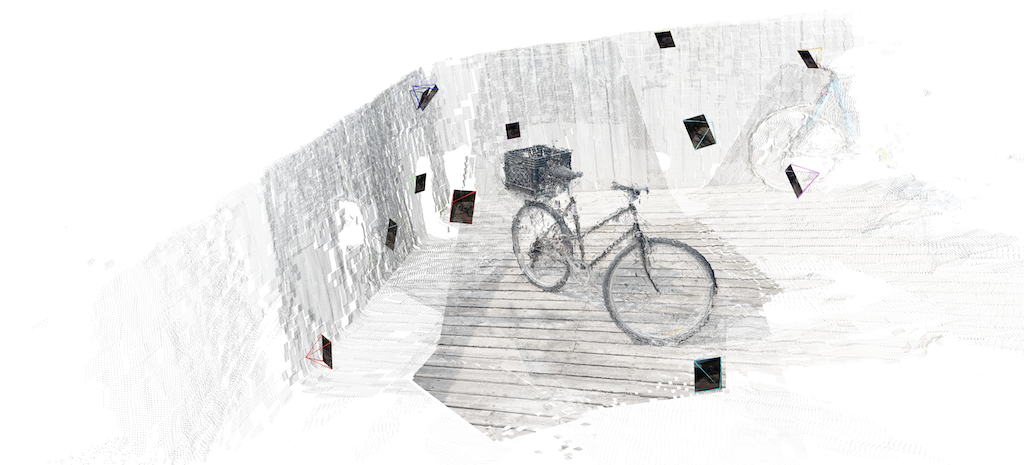

In [8]:
# # %cd /kaggle/working/mast3r
# !PYTHONPATH="/kaggle/input/mast3r-fix/mast3r/asmk:$PYTHONPATH" python3 /kaggle/input/mast3r-fix/mast3r/demo.py --weights /kaggle/input/mast3r-fix/mast3r/checkpoints/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric.pth --share

In [9]:
import random
import os
import numpy as np
import torch
import dataclasses

def seed_everything(seed: int = 42):
    """Set seed for reproducibility across random, numpy, torch (CPU + CUDA)."""
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # for multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything()

In [10]:
import sys
import os
from tqdm import tqdm
from time import time, sleep
import gc
import numpy as np
import h5py
import dataclasses
import pandas as pd
from IPython.display import clear_output
from collections import defaultdict
from copy import deepcopy
from PIL import Image

import cv2
import torch
import torch.nn.functional as F

import torch
from transformers import AutoImageProcessor, AutoModel


# IMPORTANT Utilities: importing data into colmap and competition metric
import pycolmap
sys.path.append('/kaggle/input/imc25-utils')
from database import *
from h5_to_db import *
import metric

from fastprogress import progress_bar

2025-06-12 09:42:54.444406: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749721374.467577     364 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749721374.474464     364 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [11]:
from mast3r.model import AsymmetricMASt3R
from mast3r.fast_nn import fast_reciprocal_NNs

import mast3r.utils.path_to_dust3r
from dust3r.inference import inference
from dust3r.utils.image import load_images

In [12]:
!rm -rf /kaggle/working/result


In [13]:
# Configuration
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu' # Automatically use GPU if available
print(f"Using device: {device}")

schedule = 'cosine' # These seem to be unused in the provided snippet, but keep for context
lr = 0.01
niter = 300
local_model_directory = "/kaggle/input/mast3r-fix/mast3r/checkpoints/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric.pth"

# Now, we manually call `load_model` as suggested by `mast3r/model.py`'s `from_pretrained` logic
from mast3r.model import load_model # Assuming load_model is defined in mast3r/model.py or accessible

print(f"Loading model from local path: {local_model_directory}")
mast3r_model = load_model(local_model_directory, device=device) # Pass device to load_model
print("Model loaded successfully.")

Using device: cuda
Loading model from local path: /kaggle/input/mast3r-fix/mast3r/checkpoints/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric.pth
... loading model from /kaggle/input/mast3r-fix/mast3r/checkpoints/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric.pth


/kaggle/input/mast3r-fix/mast3r/mast3r/model.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(model_path, map_location='cpu')


instantiating : AsymmetricMASt3R(enc_depth=24, dec_depth=12, enc_embed_dim=1024, dec_embed_dim=768, enc_num_heads=16, dec_num_heads=12, pos_embed='RoPE100',img_size=(512, 512), head_type='catmlp+dpt', output_mode='pts3d+desc24', depth_mode=('exp', -inf, inf), conf_mode=('exp', 1, inf), patch_embed_cls='PatchEmbedDust3R', two_confs=True, desc_conf_mode=('exp', 0, inf), landscape_only=False)
<All keys matched successfully>
Model loaded successfully.


In [14]:
def transform_keypoints_to_original(
    kpts_crop: np.ndarray,
    original_size: tuple[int, int],#H,W
    size_param: int = 512, # The 'size' parameter (e.g., 224, 512) used in load_images
    square_ok: bool = False
) -> np.ndarray:
    """
    Transforms keypoint coordinates from a DUST3R-processed (resized and cropped)
    image back to the original image's coordinate system.

    Args:
        kpts_crop: A NumPy array of shape (N, 2) where N is the number of keypoints,
                   and each row is (x, y) coordinate on the processed image.
        original_size: A tuple (original_width, original_height) of the original image.
        resized_crop_size: A tuple (processed_width, processed_height) of the
                           image after resizing and cropping (i.e., the dimensions
                           of the input image to DUST3R). This is W2, H2 from the
                           load_images function.
        size_param: The 'size' parameter (e.g., 224, 512) used in the
                    original load_images function.
        square_ok: The 'square_ok' parameter used in the original load_images function.

    Returns:
        A NumPy array of shape (N, 2) with the transformed keypoint coordinates
        on the original image.
    """
    # print(f"original_size: {original_size}")
    original_height, original_width = original_size
    original_height = float(original_height)
    original_width = float(original_width)

    # --- 1. Determine the dimensions after resizing but *before* cropping (W_res, H_res) ---
    # This logic mirrors the _resize_pil_image call in load_images
    if size_param == 224:
        # Target long side is used for resizing.
        target_long_side = round(size_param * max(original_width / original_height, original_height / original_width))
        if original_width >= original_height:
            W_res = target_long_side
            H_res = round(original_height * (target_long_side / original_width))
        else:
            H_res = target_long_side
            W_res = round(original_width * (target_long_side / original_height))
    else:
        # Long side is resized to size_param.
        if original_width >= original_height:
            W_res = size_param
            H_res = round(original_height * (size_param / original_width))
        else:
            H_res = size_param
            W_res = round(original_width * (size_param / original_height))

    # print(f"H_res, W_res: {H_res}_{W_res}")

    # --- 2. Calculate the cropping offsets used during processing ---
    cx, cy = W_res // 2, H_res // 2

    if size_param == 224:
        half = min(cx, cy)
        crop_left = cx - half
        crop_top = cy - half
    else:
        halfw = ((2 * cx) // 16) * 8
        halfh = ((2 * cy) // 16) * 8
        if not square_ok and W_res == H_res:
            halfh = round(3 * halfw / 4)
        
        crop_left = cx - halfw
        crop_top = cy - halfh

    

    # --- 4. Reverse the Resizing ---
    # Determine the actual scaling factor applied during the initial resize
    if original_width >= original_height:
        scale_factor = size_param / original_width
    else:
        scale_factor = size_param / original_height
    # --- 3. Reverse the Cropping ---
    # Add the crop offsets to the keypoints from the cropped image
    # print(crop_left, crop_top)
    kpts_resized = kpts_crop.astype(float) # Ensure float for accurate division
    kpts_resized[:, 0] = kpts_resized[:, 0] + crop_left
    kpts_resized[:, 1] = kpts_resized[:, 1] + crop_top


    
    # Divide by the scale factor to get original coordinates
    kpts_original = kpts_resized/ scale_factor 

    return kpts_original

In [15]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

def draw_matches_on_original_images(img_path1, img_path2, matches_im0, matches_im1, save_path, n_viz=100):
    """
    画出两张原图上的匹配点连线，并保存图像

    Args:
        img_path1: str, 原图1路径
        img_path2: str, 原图2路径
        matches_im0: (N, 2) numpy array，图1上的匹配点坐标（在原图上）
        matches_im1: (N, 2) numpy array，图2上的匹配点坐标（在原图上）
        save_path: str, 输出图像路径
        n_viz: int, 可视化前n个匹配（默认100）
    """
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    # 读取图像
    img0 = cv2.imread(img_path1)
    img1 = cv2.imread(img_path2)
    key1 = os.path.basename(img_path1)
    key2 = os.path.basename(img_path2)


    if img0 is None or img1 is None:
        print(f"Error: Cannot load {img_path1} or {img_path2}")
        return

    img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

    H0, W0 = img0.shape[:2]
    H1, W1 = img1.shape[:2]
    canvas_h = max(H0, H1)
    canvas = np.zeros((canvas_h, W0 + W1, 3), dtype=np.uint8)
    canvas[:H0, :W0] = img0
    canvas[:H1, W0:] = img1

    # 可视化子集
    num_matches = min(len(matches_im0), n_viz)
    idxs = np.round(np.linspace(0, len(matches_im0) - 1, num_matches)).astype(int)
    cmap = plt.get_cmap('rainbow')

    for i, idx in enumerate(idxs):
        (x0, y0) = matches_im0[idx]
        (x1, y1) = matches_im1[idx]
        color = tuple((np.array(cmap(i / n_viz))[:3] * 255).astype(int).tolist())

        pt1 = (int(round(x0)), int(round(y0)))
        pt2 = (int(round(x1 + W0)), int(round(y1)))

        cv2.line(canvas, pt1, pt2, color, thickness=1, lineType=cv2.LINE_AA)
        cv2.circle(canvas, pt1, 2, color, -1, lineType=cv2.LINE_AA)
        cv2.circle(canvas, pt2, 2, color, -1, lineType=cv2.LINE_AA)

    # 保存
    cv2.imwrite(f'{save_path}/{key1}_{key2}.jpg', cv2.cvtColor(canvas, cv2.COLOR_RGB2BGR))
    print(f"Saved match debug image to {save_path}")


>> Loading a list of 2 images
 - adding /kaggle/input/image-matching-challenge-2025/train/ETs/et_et003.png with resolution 480x640 --> 384x512
 - adding /kaggle/input/image-matching-challenge-2025/train/ETs/et_et006.png with resolution 480x640 --> 384x512
 (Found 2 images)
>> Inference with model on 1 image pairs


  0%|          | 0/1 [00:00<?, ?it/s]/kaggle/input/mast3r-fix/mast3r/dust3r/dust3r/inference.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=bool(use_amp)):
/kaggle/input/mast3r-fix/mast3r/dust3r/dust3r/model.py:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/kaggle/input/mast3r-fix/mast3r/dust3r/dust3r/inference.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


512 384 512 384


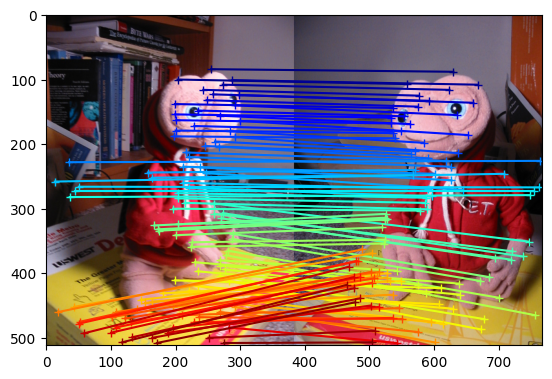

Saved match debug image to /kaggle/working/temp


In [16]:
img_path1 = '/kaggle/input/image-matching-challenge-2025/train/ETs/et_et003.png'
img_path2 = '/kaggle/input/image-matching-challenge-2025/train/ETs/et_et006.png'
images = load_images([img_path1, img_path2], size=512)
output = inference([tuple(images)], mast3r_model, device, batch_size=1, verbose=True)

# at this stage, you have the raw dust3r predictions
view1, pred1 = output['view1'], output['pred1']
view2, pred2 = output['view2'], output['pred2']

desc1, desc2 = pred1['desc'].squeeze(0).detach(), pred2['desc'].squeeze(0).detach()

# find 2D-2D matches between the two images
matches_im0, matches_im1 = fast_reciprocal_NNs(desc1, desc2, subsample_or_initxy1=8,
                                               device=device, dist='dot', block_size=2**13)

# ignore small border around the edge
H0, W0 = view1['true_shape'][0]
valid_matches_im0 = (matches_im0[:, 0] >= 3) & (matches_im0[:, 0] < int(W0) - 3) & (
    matches_im0[:, 1] >= 3) & (matches_im0[:, 1] < int(H0) - 3)

H1, W1 = view2['true_shape'][0]
valid_matches_im1 = (matches_im1[:, 0] >= 3) & (matches_im1[:, 0] < int(W1) - 3) & (
    matches_im1[:, 1] >= 3) & (matches_im1[:, 1] < int(H1) - 3)

valid_matches = valid_matches_im0 & valid_matches_im1
matches_im0, matches_im1 = matches_im0[valid_matches], matches_im1[valid_matches]

# visualize a few matches
import numpy as np
import torch
import torchvision.transforms.functional
from matplotlib import pyplot as pl

n_viz = 100
num_matches = matches_im0.shape[0]
match_idx_to_viz = np.round(np.linspace(0, num_matches - 1, n_viz)).astype(int)
viz_matches_im0, viz_matches_im1 = matches_im0[match_idx_to_viz], matches_im1[match_idx_to_viz]

image_mean = torch.as_tensor([0.5, 0.5, 0.5], device='cpu').reshape(1, 3, 1, 1)
image_std = torch.as_tensor([0.5, 0.5, 0.5], device='cpu').reshape(1, 3, 1, 1)

viz_imgs = []
for i, view in enumerate([view1, view2]):
    rgb_tensor = view['img'] * image_std + image_mean
    viz_imgs.append(rgb_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy())

H0, W0, H1, W1 = *viz_imgs[0].shape[:2], *viz_imgs[1].shape[:2]
print(H0,W0,H1,W1)
img0 = np.pad(viz_imgs[0], ((0, max(H1 - H0, 0)), (0, 0), (0, 0)), 'constant', constant_values=0)
img1 = np.pad(viz_imgs[1], ((0, max(H0 - H1, 0)), (0, 0), (0, 0)), 'constant', constant_values=0)
img = np.concatenate((img0, img1), axis=1)
pl.figure()
pl.imshow(img)
cmap = pl.get_cmap('jet')
for i in range(n_viz):
    (x0, y0), (x1, y1) = viz_matches_im0[i].T, viz_matches_im1[i].T
    pl.plot([x0, x1 + W0], [y0, y1], '-+', color=cmap(i / (n_viz - 1)), scalex=False, scaley=False)
pl.show(block=True)

img0 = cv2.imread(img_path1)
img1 = cv2.imread(img_path2)
H0, W0 = img0.shape[:2]
H1, W1 = img1.shape[:2]
viz_matches_im0_org = transform_keypoints_to_original(viz_matches_im0, (H0, W0))
viz_matches_im1_org = transform_keypoints_to_original(viz_matches_im1, (H1, W1))

out_org_dir= os.path.join("/kaggle/working", "temp")
os.makedirs(out_org_dir, exist_ok=True)

draw_matches_on_original_images(img_path1, img_path2, viz_matches_im0_org, viz_matches_im1_org, out_org_dir, n_viz=100)

In [17]:
def get_img_pairs_exhaustive(img_fnames):
    index_pairs = []
    for i in range(len(img_fnames)):
        for j in range(i+1, len(img_fnames)):
            index_pairs.append((i,j))
    return index_pairs

In [18]:
import kornia as K
import kornia.feature as KF
# --- Helper function for image loading (if not already defined) ---
def load_torch_image(fname, device=torch.device('cpu')):
    img = K.io.load_image(fname, K.io.ImageLoadType.RGB32, device=device)[None, ...]
    return img

In [19]:
# Must Use efficientnet global descriptor to get matching shortlists.
def get_global_desc(fnames, device = torch.device('cpu')):
    processor = AutoImageProcessor.from_pretrained('/kaggle/input/dinov2/pytorch/base/1')
    model = AutoModel.from_pretrained('/kaggle/input/dinov2/pytorch/base/1')
    model = model.eval()
    model = model.to(device)
    global_descs_dinov2 = []
    for i, img_fname_full in tqdm(enumerate(fnames),total= len(fnames)):
        key = os.path.splitext(os.path.basename(img_fname_full))[0]
        timg = load_torch_image(img_fname_full)
        with torch.inference_mode():
            inputs = processor(images=timg, return_tensors="pt", do_rescale=False).to(device)
            outputs = model(**inputs)
            dino_mac = F.normalize(outputs.last_hidden_state[:,1:].max(dim=1)[0], dim=1, p=2)
        global_descs_dinov2.append(dino_mac.detach().cpu())
    global_descs_dinov2 = torch.cat(global_descs_dinov2, dim=0)
    return global_descs_dinov2


def get_img_pairs_exhaustive(img_fnames):
    index_pairs = []
    for i in range(len(img_fnames)):
        for j in range(i+1, len(img_fnames)):
            index_pairs.append((i,j))
    return index_pairs

In [20]:
def get_image_pairs_shortlist_org(fnames,
                              sim_th = 0.6, # should be strict
                              min_pairs = 60,
                              exhaustive_if_less = 20,
                              device=torch.device('cpu')):
    num_imgs = len(fnames)
    if num_imgs <= exhaustive_if_less:
        return get_img_pairs_exhaustive(fnames)
    descs = get_global_desc(fnames, device=device)
    dm = torch.cdist(descs, descs, p=2).detach().cpu().numpy()

    
    mask = dm <= sim_th
    total = 0
    matching_list = []
    ar = np.arange(num_imgs)
    already_there_set = []
    for st_idx in range(num_imgs-1):
        mask_idx = mask[st_idx]
        to_match = ar[mask_idx]
        if len(to_match) < min_pairs:
            to_match = np.argsort(dm[st_idx])[:min_pairs]  
        for idx in to_match:
            if st_idx == idx:
                continue
            if dm[st_idx, idx] < 10000:
                matching_list.append(tuple(sorted((st_idx, idx.item()))))
                total+=1
    matching_list = sorted(list(set(matching_list)))
    return matching_list

In [21]:
def reconstruct_from_db(feature_dir, img_dir):
    result = {}
    local_timings = {'RANSAC': [], 'Reconstruction': []}
    #############################################################
    # regist keypoints from h5 into colmap db
    #############################################################
    database_path = f'{feature_dir}/colmap.db'
    if os.path.isfile(database_path):
        os.remove(database_path)
    gc.collect()
    import_into_colmap(img_dir, feature_dir=feature_dir, database_path=database_path)
    output_path = f'{feature_dir}/colmap_rec'
    os.makedirs(output_path, exist_ok=True)
    print("colmap database")
    #############################################################
    # Calculate fundamental matrix with colmap api
    #############################################################
    t=time()
    # options = pycolmap.SiftMatchingOptions()
    # options.confidence = 0.9999
    # options.max_num_trials = 20000
    # pycolmap.match_exhaustive(database_path, sift_options=options)
    pycolmap.match_exhaustive(database_path)
    # print("matching done!!!!")
    local_timings['RANSAC'].append(time() - t)
    print(f'RANSAC in {local_timings["RANSAC"][-1]:.4f} sec')

    #############################################################
    # Execute bundle adjustmnet with colmap api
    # --> Bundle adjustment Calcs Camera matrix, R and t
    #############################################################
    t=time()
    # By default colmap does not generate a reconstruction if less than 10 images are registered. Lower it to 3.
    mapper_options = pycolmap.IncrementalPipelineOptions()
    # mapper_options.mapper.filter_max_reproj_error	 = 10.0
    mapper_options.min_model_size = 8
    mapper_options.max_num_models = 25
    maps = pycolmap.incremental_mapping(database_path=database_path, image_path=img_dir, 
                                        output_path=output_path, options=mapper_options)
    print(maps)
    for map_index, rec in maps.items():
        result[map_index] = {}
        for img_id, image in rec.images.items():
            result[map_index][image.name] = {
                'R': image.cam_from_world.rotation.matrix().tolist(),
                't': image.cam_from_world.translation.tolist()
            }
    # clear_output(wait=False)
    local_timings['Reconstruction'].append(time() - t)
    print(f'Reconstruction done in {local_timings["Reconstruction"][-1]:.4f} sec')

    #############################################################
    # Extract R,t from maps 
    #############################################################            
    return result, local_timings

In [22]:
# Collect vital info from the dataset

@dataclasses.dataclass
class Prediction:
    image_id: str | None  # A unique identifier for the row -- unused otherwise. Used only on the hidden test set.
    dataset: str
    filename: str
    cluster_index: int | None = None
    rotation: np.ndarray | None = None
    translation: np.ndarray | None = None

# Set is_train=True to run the notebook on the training data.
# Set is_train=False if submitting an entry to the competition (test data is hidden, and different from what you see on the "test" folder).
is_train = True
data_dir = '/kaggle/input/image-matching-challenge-2025'
workdir = '/kaggle/working/result/'
os.makedirs(workdir, exist_ok=True)

if is_train:
    sample_submission_csv = os.path.join(data_dir, 'train_labels.csv')
else:
    sample_submission_csv = os.path.join(data_dir, 'sample_submission.csv')

samples = {}
competition_data = pd.read_csv(sample_submission_csv)
for _, row in competition_data.iterrows():
    # Note: For the test data, the "scene" column has no meaning, and the rotation_matrix and translation_vector columns are random.
    if row.dataset not in samples:
        samples[row.dataset] = []
    samples[row.dataset].append(
        Prediction(
            image_id=None if is_train else row.image_id,
            dataset=row.dataset,
            filename=row.image
        )
    )

for dataset in samples:
    print(f'Dataset "{dataset}" -> num_images={len(samples[dataset])}')

Dataset "imc2023_haiper" -> num_images=54
Dataset "imc2023_heritage" -> num_images=209
Dataset "imc2023_theather_imc2024_church" -> num_images=76
Dataset "imc2024_dioscuri_baalshamin" -> num_images=138
Dataset "imc2024_lizard_pond" -> num_images=214
Dataset "pt_brandenburg_british_buckingham" -> num_images=225
Dataset "pt_piazzasanmarco_grandplace" -> num_images=168
Dataset "pt_sacrecoeur_trevi_tajmahal" -> num_images=225
Dataset "pt_stpeters_stpauls" -> num_images=200
Dataset "amy_gardens" -> num_images=200
Dataset "fbk_vineyard" -> num_images=163
Dataset "ETs" -> num_images=22
Dataset "stairs" -> num_images=51


In [23]:
import multiprocessing

In [24]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2


def save_match_viz_image(
    key1,
    key2,
    view1,
    view2,
    matches_im0,
    matches_im1,
    feature_dir,
    n_viz: int = 100
):
    """
    Save a visual match image for a pair of images using descriptor matches.

    Parameters:
        key1, key2: str
            Base filenames of the matched image pair (used for naming the output).
        view1, view2: dict
            MASt3R inference outputs containing 'img' and 'true_shape'.
        matches_im0, matches_im1: np.ndarray of shape (N, 2)
            Coordinates of matched keypoints in image 0 and image 1.
        feature_dir: str
            Path to save the visualized match image.
        n_viz: int
            Number of matches to visualize (default: 100).
    """
    if matches_im0.shape[0] == 0:
        return  # nothing to draw

    n_viz = min(n_viz, matches_im0.shape[0])
    idx = np.round(np.linspace(0, matches_im0.shape[0] - 1, n_viz)).astype(int)
    viz_matches_im0 = matches_im0[idx]
    viz_matches_im1 = matches_im1[idx]

    image_mean = torch.tensor([0.5, 0.5, 0.5]).reshape(1, 3, 1, 1)
    image_std = torch.tensor([0.5, 0.5, 0.5]).reshape(1, 3, 1, 1)

    viz_imgs = []
    for view in [view1, view2]:
        rgb_tensor = view['img'].cpu() * image_std + image_mean
        rgb_np = rgb_tensor.squeeze(0).permute(1, 2, 0).clamp(0, 1).numpy()
        viz_imgs.append((rgb_np * 255).astype(np.uint8))

    H0, W0 = viz_imgs[0].shape[:2]
    H1, W1 = viz_imgs[1].shape[:2]
    img0 = np.pad(viz_imgs[0], ((0, max(H1 - H0, 0)), (0, 0), (0, 0)), 'constant')
    img1 = np.pad(viz_imgs[1], ((0, max(H0 - H1, 0)), (0, 0), (0, 0)), 'constant')
    img = np.concatenate((img0, img1), axis=1)

    cmap = plt.get_cmap('jet')
    for i in range(n_viz):
        (x0, y0), (x1, y1) = viz_matches_im0[i].T, viz_matches_im1[i].T
        color = tuple(int(c * 255) for c in cmap(i / (n_viz - 1))[:3])
        cv2.line(img, (int(x0), int(y0)), (int(x1 + W0), int(y1)), color, thickness=1)
        cv2.circle(img, (int(x0), int(y0)), radius=2, color=color, thickness=-1)
        cv2.circle(img, (int(x1 + W0), int(y1)), radius=2, color=color, thickness=-1)

    out_dir = os.path.join(feature_dir, "debug_vis")
    os.makedirs(out_dir, exist_ok=True)
    out_path = os.path.join(out_dir, f"{key1}-{key2}.jpg")
    cv2.imwrite(out_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    print(f"[Match Debug] Saved to {out_path}")


In [25]:
import numpy as np
from collections import defaultdict

def simple_unify_keypoints_and_matches(unique_keypoints, out_match, round_digits=1):
    # Step 1: 拉平所有点坐标
    all_pts = []
    pt_group_info = []  # 记录属于哪个图像、第几组、第几个点

    for img, kpt_groups in unique_keypoints.items():
        for group_idx, kpts in enumerate(kpt_groups):
            for i, pt in enumerate(kpts):
                all_pts.append(np.round(pt, round_digits))
                pt_group_info.append((img, group_idx))

    all_pts = np.array(all_pts)
    
    # Step 2: 去重并获取每个点的 global_id
    unique_pts, inverse = np.unique(all_pts, axis=0, return_inverse=True)

    # Step 3: 还原 global_id 到每张图的每组 keypoints
    global_keypoint_ids = defaultdict(list)
    offset = 0
    for img, kpt_groups in unique_keypoints.items():
        for kpts in kpt_groups:
            count = len(kpts)
            ids = inverse[offset:offset+count]
            global_keypoint_ids[img].append(ids)
            offset += count

    # Step 4: 用 global_id 更新每对匹配
    pair_counter = defaultdict(int)
    global_matches = {}

    for key1 in out_match:
        for key2 in out_match[key1]:
            match = out_match[key1][key2]  # shape (N, 4), [x0, y0, x1, y1]
            N = match.shape[0]
            idx1 = pair_counter[key1]
            idx2 = pair_counter[key2]
            ids0 = global_keypoint_ids[key1][idx1]
            ids1 = global_keypoint_ids[key2][idx2]
            global_matches[(key1, key2)] = np.stack([ids0, ids1], axis=1)
            pair_counter[key1] += 1
            pair_counter[key2] += 1

    return unique_pts, global_keypoint_ids, global_matches


In [26]:
def match_with_mast3r_and_save(index_pairs, image_list, feature_dir, model, device, lock):
    os.makedirs(feature_dir, exist_ok=True)
    cache = {}
    unique_keypoints = defaultdict(list)
    out_match = defaultdict(dict)
    local_cache = {}
    
    out_dir = os.path.join(feature_dir, "pair_res")
    out_org_dir= os.path.join(feature_dir, "pair_res_onorg")
    os.makedirs(out_dir, exist_ok=True)
    os.makedirs(out_org_dir, exist_ok=True)
    
    for idx1, idx2 in tqdm(index_pairs):
        name1, name2 = image_list[idx1], image_list[idx2]
        key1, key2 = os.path.basename(name1), os.path.basename(name2)

        # Only re-run inference for key1 if not in cache
        images = load_images([name1, name2], size=512, verbose=False)
        output = inference([tuple(images)], mast3r_model, device, batch_size=1, verbose=False)
        
        # at this stage, you have the raw dust3r predictions
        view1, pred1 = output['view1'], output['pred1']
        view2, pred2 = output['view2'], output['pred2']
        
        desc1, desc2 = pred1['desc'].squeeze(0).detach(), pred2['desc'].squeeze(0).detach()

        matches_im0, matches_im1 = fast_reciprocal_NNs(desc1, desc2, subsample_or_initxy1=8, device=device)
        print(f"get pair for {key1}_{key2}, {len(matches_im0)}")

        H0, W0 = view1['true_shape'][0].tolist()
        H1, W1 = view2['true_shape'][0].tolist()
        
        valid0 = (matches_im0[:, 0] >= 3) & (matches_im0[:, 0] < W0 - 3) & (matches_im0[:, 1] >= 3) & (matches_im0[:, 1] < H0 - 3)
        valid1 = (matches_im1[:, 0] >= 3) & (matches_im1[:, 0] < W1 - 3) & (matches_im1[:, 1] >= 3) & (matches_im1[:, 1] < H1 - 3)
        valid = valid0 & valid1

        matches_im0 = matches_im0[valid]
        matches_im1 = matches_im1[valid]
        if len(matches_im0) < CONFIG.MAST3R_MIN_PAIR:
            continue
        # print("transform_keypoints_to_original begin")
        
        img0 = cv2.imread(img_path1)
        img1 = cv2.imread(img_path2)
        H0, W0 = img0.shape[:2]
        H1, W1 = img1.shape[:2]
        matches_im0_org = transform_keypoints_to_original(matches_im0, (H0, W0))
        matches_im1_org = transform_keypoints_to_original(matches_im1, (H1, W1))

        # matches_im0_org = transform_keypoints_to_original(matches_im0, view1['true_shape'][0].tolist())
        # matches_im1_org = transform_keypoints_to_original(matches_im1, view2['true_shape'][0].tolist())
        # print("transform_keypoints_to_original end")

        unique_keypoints[key1].append(matches_im0_org)
        unique_keypoints[key2].append(matches_im1_org)
        out_match[key1][key2] = np.concatenate([matches_im1_org, matches_im1_org], axis=1)
        if False:
            save_match_viz_image(key1, key2, view1, view2, matches_im0, matches_im1, out_dir)
        if True:
            draw_matches_on_original_images(name1, name2, matches_im0_org, matches_im1_org, out_org_dir)
    
    print("out of loop")

    keypoints_unified = {}
    keypoints_id_map = {}
    out_match_unified = defaultdict(dict)

    keypoints_unified, global_ids, out_match_unified = simple_unify_keypoints_and_matches(unique_keypoints, out_match)


    print("points and matches unified")
    save_kpts_file = f'{feature_dir}/keypoints.h5'
    save_matches_file = f'{feature_dir}/matches.h5'

    if lock is None:
        lock = Lock()

    with lock:
        for f in [save_kpts_file, save_matches_file]:
            if os.path.exists(f):
                os.remove(f)

        with h5py.File(save_kpts_file, 'w') as f_kp:
            for name, pts in keypoints_unified.items():
                if name in f_kp:
                    del f_kp[name]
                f_kp.create_dataset(name, data=pts)

        print("keypoints file done")

        with h5py.File(save_matches_file, mode='w') as f_match:
            for k1, match_group in out_match_unified.items():
                g = f_match.require_group(k1)
                for k2, matches in match_group.items():
                    if k2 in g:
                        del g[k2]
                    if len(matches) > 0:
                        g[k2] = matches.astype(np.int32)

    print(f"Saved keypoints and matches to {feature_dir}")


In [27]:
# def match_with_mast3r_and_save(index_pairs, image_list, feature_dir, model, device, lock):
#     os.makedirs(feature_dir, exist_ok=True)
#     cache = {}
#     unique_keypoints = defaultdict(list)
#     out_match = defaultdict(dict)

#     # Step 1: Load all unique images
#     unique_img_paths = sorted(set([image_list[i] for pair in index_pairs for i in pair]))
#     img_tensors = load_images(unique_img_paths, size=512)
#     img_name_to_tensor = {name: img for name, img in zip(unique_img_paths, img_tensors)}

#     # Step 2: Prepare inference in 2-image batches
#     names = list(img_name_to_tensor.keys())
#     tensors = list(img_name_to_tensor.values())

#     if len(tensors) % 2 != 0:
#         tensors.append(tensors[-1])
#         names.append(names[-1])

#     paired_tensors = [(tensors[i], tensors[i + 1]) for i in range(0, len(tensors), 2)]
#     paired_names = [(names[i], names[i + 1]) for i in range(0, len(names), 2)]

#     outputs = inference(paired_tensors, model, device=device, batch_size=2)

#     view1, pred1 = outputs['view1'], outputs['pred1']
#     view2, pred2 = outputs['view2'], outputs['pred2']

#     print(f"outputs: {len(outputs)}, {len(pred1)}, {len(paired_names)}")
    
#     # 缓存 desc 和 true_shape
#     for i, (name1, name2) in enumerate(paired_names):
#         key1 = os.path.basename(name1)
#         key2 = os.path.basename(name2) 
#         if key1 not in cache:
#             cache[key1] = {
#                 'desc': pred1['desc'][i].squeeze(0).detach(),
#                 'true_shape': view1['true_shape'][i].tolist()
#             }
#         if key2 not in cache:
#             cache[key2] = {
#                 'desc': pred2['desc'][i].squeeze(0).detach(),
#                 'true_shape': view2['true_shape'][i].tolist()
#             }
#     # print("caching done")
#     # Step 3: Matching and unified keypoint indexing
#     match_buffer = defaultdict(list)
#     for idx1, idx2 in tqdm(index_pairs):
#         name1, name2 = image_list[idx1], image_list[idx2]
#         key1 = os.path.basename(name1)
#         key2 = os.path.basename(name2) 
#         desc1, desc2 = cache[key1]['desc'], cache[key2]['desc']
#         matches_im0, matches_im1 = fast_reciprocal_NNs(desc1, desc2, subsample_or_initxy1=8, device=device)
#         print(f"get pair for {key1}_{key2}, {len(matches_im0)}")
#         H0, W0 = cache[key1]['true_shape']
#         H1, W1 = cache[key2]['true_shape']
#         valid0 = (matches_im0[:, 0] >= 3) & (matches_im0[:, 0] < W0 - 3) & (matches_im0[:, 1] >= 3) & (matches_im0[:, 1] < H0 - 3)
#         valid1 = (matches_im1[:, 0] >= 3) & (matches_im1[:, 0] < W1 - 3) & (matches_im1[:, 1] >= 3) & (matches_im1[:, 1] < H1 - 3)
#         valid = valid0 & valid1

#         matches_im0 = matches_im0[valid]
#         matches_im1 = matches_im1[valid]
#         if len(matches_im0) < CONFIG.MAST3R_MIN_PAIR:
#             continue

#         match_buffer[key1].append(matches_im0)
#         match_buffer[key2].append(matches_im1)
#         out_match[key1][key2] = np.concatenate([matches_im0, matches_im1], axis=1)
#     # print("filter match")
#     # Step 4: unify keypoints with ID and save
#     keypoints_unified = {}
#     keypoints_id_map = {}
#     for name, pts_list in match_buffer.items():
#         pts = np.concatenate(pts_list, axis=0)
#         unique_pts, inverse = torch.unique(torch.from_numpy(np.round(pts)), dim=0, return_inverse=True)
#         keypoints_unified[name] = unique_pts.numpy()
#         keypoints_id_map[name] = inverse
#     # print("uqnified pts")
#     # Step 5: remap matches to keypoint ids
#     for k1, group in out_match.items():
#         for k2, m in group.items():
#             ids0 = keypoints_id_map[k1][:len(m)]
#             ids1 = keypoints_id_map[k2][:len(m)]
#             out_match[k1][k2] = np.stack([ids0.numpy(), ids1.numpy()], axis=1)
#     # print("uniqfied matches")
    
#     # Save
#     save_kpts_file = f'{feature_dir}/keypoints.h5'
#     save_matches_file = f'{feature_dir}/matches.h5'

#     if lock is None:
#         lock = Lock()  # 如果没有传入，就自己建一个（用于单线程）

#     with lock:
#         # Remove old files (safe)
#         for f in [save_kpts_file, save_matches_file]:
#             if os.path.exists(f):
#                 os.remove(f)

#         with h5py.File(save_kpts_file, 'w') as f_kp:
#             for name, pts in keypoints_unified.items():
#                 if name in f_kp:
#                     del f_kp[name]
#                 f_kp.create_dataset(name, data=pts)
#         print("keypoints file done")
        
#         with h5py.File(save_matches_file, mode='w') as f_match:
#             for k1, match_group in out_match.items():
#                 g = f_match.require_group(k1)
#                 for k2, matches in match_group.items():
#                     if k2 in g:
#                         del g[k2]
#                         if len(matches)>0:
#                             g[k2] = matches  # shape (M, 2), dtype=int32
                    
#         # with h5py.File(save_matches_file, 'w') as f_match:
#         #     for k1, group in out_match.items():
#         #         g = f_match.require_group(k1)
#         #         for k2, m in group.items():
#         #             if k2 in g:
#         #                 del g[k2]
#         #             g.create_dataset(k2, data=m.astype(np.int32))

#     print(f"Saved keypoints and matches to {feature_dir}")


In [28]:
import cv2
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches


def draw_keypoints_and_matches(images_input, unified_kp_path, remapped_matches_path, feature_dir='visualization_output'):
    output_dir = os.path.join(feature_dir, 'visualization_output')
    os.makedirs(output_dir, exist_ok=True)

    # Load images and determine image_keys for HDF5 lookup
    if isinstance(images_input[0], str):
        loaded_images = [cv2.imread(img_path) for img_path in images_input]
        image_keys = [os.path.basename(img_path) for img_path in images_input]
    else:
        loaded_images = images_input
        # If images_input are already arrays, you need to provide the corresponding keys
        # This part is crucial: image_keys MUST align with the HDF5 keys
        image_keys = image_keys_in_h5 # Use the predefined list for the dummy case

    # Load unified keypoints
    keypoints_data = {}
    with h5py.File(unified_kp_path, 'r') as f_kp:
        for img_name_raw in f_kp.keys():
            img_name = img_name_raw.decode('utf-8') if isinstance(img_name_raw, bytes) else img_name_raw
            keypoints_data[img_name] = f_kp[img_name_raw][()] # Access with raw key if bytes

    # Load remapped matches - CORRECTED LOGIC
    # Store (img1_key, img2_key) directly with matches for robust iteration
    matches_data_pairs = [] # Will store (img1_key, img2_key, matches_array)
    with h5py.File(remapped_matches_path, 'r') as f_matches:
        print("\n--- Loading remapped matches from HDF5 ---")
        for img1_group_key_candidate in tqdm(f_matches.keys(), desc="Loading matches"):
            img1_key = img1_group_key_candidate.decode('utf-8') if isinstance(img1_group_key_candidate, bytes) else img1_group_key_candidate

            img1_group = f_matches[img1_group_key_candidate] # Access with raw key

            if isinstance(img1_group, h5py.Group):
                for img2_dataset_key_candidate in img1_group.keys():
                    img2_key = img2_dataset_key_candidate.decode('utf-8') if isinstance(img2_dataset_key_candidate, bytes) else img2_dataset_key_candidate

                    try:
                        matches_array = img1_group[img2_dataset_key_candidate][()]
                        matches_data_pairs.append((img1_key, img2_key, matches_array))
                    except Exception as e:
                        print(f"Error loading matches for pair ({img1_key}, {img2_key}): {e}")
            else:
                print(f"Warning: Expected '{img1_key}' to be a group, but found {type(img1_group)}. Skipping its contents.")


    # --- Drawing Keypoints ---
    print("\n--- Drawing Keypoints ---")
    for i, img_key in enumerate(image_keys):
        if img_key in keypoints_data:
            img = loaded_images[i].copy()
            kpts = keypoints_data[img_key]

            for kp in kpts:
                x, y = int(kp[0]), int(kp[1])
                cv2.circle(img, (x, y), 3, (0, 255, 0), -1) # Green circle for keypoint

            output_kp_path = os.path.join(output_dir, f"keypoints_{img_key}")
            if len(img.shape) == 2:
                img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
            cv2.imwrite(output_kp_path, img)
            print(f"Keypoints drawn on {img_key}, saved to {output_kp_path}")
        else:
            print(f"No keypoints found for {img_key} in unified keypoints file.")

    # --- Drawing Matches ---
    print("\n--- Drawing Matches ---")
    # Iterate through the (img1_key, img2_key, matches) tuples directly
    for img_name1, img_name2, matches in matches_data_pairs:
        # We no longer need to split img_pair_key, as we have img_name1 and img_name2 directly

        # Find the actual image objects and their keypoints using image_keys list
        try:
            img1_idx = image_keys.index(img_name1)
            img2_idx = image_keys.index(img_name2)
        except ValueError:
            print(f"Skipping matches for {img_name1}-{img_name2}: One or both image names not found in the provided 'images' list/keys.")
            continue

        img1 = loaded_images[img1_idx].copy()
        img2 = loaded_images[img2_idx].copy()

        kpts1 = keypoints_data.get(img_name1)
        kpts2 = keypoints_data.get(img_name2)

        if kpts1 is None or kpts2 is None:
            print(f"Skipping matches for {img_name1}-{img_name2}: keypoints not found for one or both images in unified keypoints.")
            continue
        if len(matches) == 0:
            print(f"No matches to draw for {img_name1}-{img_name2}.")
            continue

        # Ensure images are 3 channels for drawing lines
        if len(img1.shape) == 2:
            img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
        if len(img2.shape) == 2:
            img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)

        # Create a concatenated image for drawing matches
        h1, w1 = img1.shape[:2]
        h2, w2 = img2.shape[:2]
        max_h = max(h1, h2)
        matched_img = np.zeros((max_h, w1 + w2, 3), dtype=np.uint8)
        matched_img[0:h1, 0:w1] = img1
        matched_img[0:h2, w1:w1+w2] = img2

        num_matches_to_draw = min(len(matches), 200) # Draw up to 200 matches to avoid clutter, adjust as needed

        for i in range(num_matches_to_draw):
            match = matches[i]
            kp1_idx, kp2_idx = int(match[0]), int(match[1])

            # Bounds check for keypoint indices
            if kp1_idx >= len(kpts1) or kp2_idx >= len(kpts2):
                # print(f"Warning: Match index out of bounds for {img_name1}-{img_name2}. Skipping match {kp1_idx}-{kp2_idx}.")
                continue

            pt1 = tuple(map(int, kpts1[kp1_idx][:2]))
            pt2 = tuple(map(int, kpts2[kp2_idx][:2]))

            # Draw circles on the concatenated image
            cv2.circle(matched_img, pt1, 5, (0, 0, 255), 2) # Red circle on img1 side
            cv2.circle(matched_img, (pt2[0] + w1, pt2[1]), 5, (255, 0, 0), 2) # Blue circle on img2 side

            # Draw a line connecting the matched keypoints
            color = tuple(np.random.randint(0, 255, 3).tolist())
            cv2.line(matched_img, pt1, (pt2[0] + w1, pt2[1]), color, 1)

        output_match_path = os.path.join(output_dir, f"matches_{img_name1}_{img_name2}.png")
        cv2.imwrite(output_match_path, matched_img)
        print(f"Matches drawn between {img_name1} and {img_name2}, saved to {output_match_path}")


# Example call (replace with your actual 'images' list)
# If your 'images' are file paths:
# images_file_paths = ['path/to/your/image1.jpg', 'path/to/your/image2.jpg', ...]
# draw_keypoints_and_matches(images_file_paths, unified_kp_path, remapped_matches_path)

# If your 'images' are loaded numpy arrays (as in the dummy example above):
# draw_keypoints_and_matches(images, unified_kp_path, remapped_matches_path)

In [29]:
import os
import gc
import time
import numpy as np
import concurrent.futures
from pathlib import Path

def run_one_dataset(dataset, predictions, data_dir, workdir, is_train, model, device, lock=None):
    timings = {
        'rotation_detection': [],
        "shortlisting": [],
        "feature_matching": [],
        "RANSAC": [],
        "Reconstruction": [],
    }

    try:
        images_dir = os.path.join(data_dir, 'train' if is_train else 'test', dataset)
        images = [os.path.join(images_dir, p.filename) for p in predictions]

        print(f'Processing dataset "{dataset}": {len(images)} images')
        filename_to_index = {p.filename: idx for idx, p in enumerate(predictions)}
        feature_dir = os.path.join(workdir, 'featureout', dataset)
        os.makedirs(feature_dir, exist_ok=True)

        t = time.time()
        index_pairs = get_image_pairs_shortlist_org(
            images, sim_th=0.2, min_pairs=10,
            exhaustive_if_less=20, device=device)
        timings['shortlisting'].append(time.time() - t)
        print(f'Shortlisting done: {len(index_pairs)} pairs')
        gc.collect()

        t = time.time()
        match_with_mast3r_and_save(index_pairs, images, feature_dir, model, device, lock)
        timings['feature_matching'].append(time.time() - t)
        print(f'MASt3R matching done in {time.time() - t:.2f} sec')
        gc.collect()

        draw_keypoints_and_matches(images, f"{feature_dir}/keypoints.h5", f"{feature_dir}/matches.h5")

        maps, local_timings = reconstruct_from_db(feature_dir, images_dir)
        for k in local_timings:
            timings[k].extend(local_timings[k])

        registered = 0
        for map_index, cur_map in maps.items():
            for image_name, pose in cur_map.items():
                idx = filename_to_index[image_name]
                pred = predictions[idx]
                pred.cluster_index = map_index
                pred.rotation = np.array(pose['R'])
                pred.translation = np.array(pose['t'])
                registered += 1

        mapping_result_str = f"Dataset {dataset} -> Registered {registered} / {len(images)} images with {len(maps)} clusters"
        return mapping_result_str, timings

    except Exception as e:
        print(f"Error in dataset {dataset}: {e}")
        return f"Dataset \"{dataset}\" -> Failed!", timings


def run_mast3r_pipeline(samples, data_dir, workdir, is_train,  model, device):
    max_images = None
    datasets_to_process = ['ETs'] if is_train else list(samples.keys())

    overall_timings = {
        "shortlisting": [],
        "feature_matching": [],
        "RANSAC": [],
        "Reconstruction": [],
    }
    mapping_result_strs = []
    lock = multiprocessing.Lock()

    with concurrent.futures.ThreadPoolExecutor(max_workers=2) as executor:  # Run 2 datasets in parallel
        futures = []
        for dataset, predictions in samples.items():
            if datasets_to_process and dataset not in datasets_to_process:
                print(f"Skipping {dataset}")
                continue
            futures.append(executor.submit(run_one_dataset, dataset, predictions, data_dir, workdir, is_train, model, device, lock))

        for future in concurrent.futures.as_completed(futures):
            result_str, timings = future.result()
            mapping_result_strs.append(result_str)
            # for k in timings:
            #     overall_timings[k].extend(timings[k])

    print('\nResults')
    for s in mapping_result_strs:
        print(s)

    # print('\nTimings')
    # for k, v in overall_timings.items():
    #     print(f'{k} -> total={sum(v):.02f} sec.')


In [30]:
# Helpers
array_to_str = lambda array: ';'.join([f"{x:.09f}" for x in array])
none_to_str = lambda n: ';'.join(['nan'] * n)

submission_file = '/kaggle/working/submission.csv'
with open(submission_file, 'w') as f:
    if is_train:
        f.write('dataset,scene,image,rotation_matrix,translation_vector\n')
        for dataset, predictions in samples.items():
            for prediction in predictions:
                cluster_name = 'outliers' if prediction.cluster_index is None else f'cluster{prediction.cluster_index}'

                # ✅ `rotation` is a list of lists, flatten it
                if prediction.rotation is None:
                    rotation_str = none_to_str(9)
                else:
                    rotation_flat =  prediction.rotation.flatten()  # flatten 3x3 list -> 9 elems
                    rotation_str = array_to_str(rotation_flat)

                # ✅ `translation` is a flat list
                if prediction.translation is None:
                    translation_str = none_to_str(3)
                else:
                    translation_str = array_to_str(prediction.translation)

                f.write(f'{prediction.dataset},{cluster_name},{prediction.filename},{rotation_str},{translation_str}\n')
    else:
        f.write('image_id,dataset,scene,image,rotation_matrix,translation_vector\n')
        for dataset, predictions in samples.items():
            for prediction in predictions:
                cluster_name = 'outliers' if prediction.cluster_index is None else f'cluster{prediction.cluster_index}'

                if prediction.rotation is None:
                    rotation_str = none_to_str(9)
                else:
                    rotation_flat =  prediction.rotation.flatten()
                    rotation_str = array_to_str(rotation_flat)

                if prediction.translation is None:
                    translation_str = none_to_str(3)
                else:
                    translation_str = array_to_str(prediction.translation)

                f.write(f'{prediction.image_id},{prediction.dataset},{cluster_name},{prediction.filename},{rotation_str},{translation_str}\n')

# Preview the output
!head {submission_file}


dataset,scene,image,rotation_matrix,translation_vector
imc2023_haiper,outliers,fountain_image_116.png,nan;nan;nan;nan;nan;nan;nan;nan;nan,nan;nan;nan
imc2023_haiper,outliers,fountain_image_108.png,nan;nan;nan;nan;nan;nan;nan;nan;nan,nan;nan;nan
imc2023_haiper,outliers,fountain_image_101.png,nan;nan;nan;nan;nan;nan;nan;nan;nan,nan;nan;nan
imc2023_haiper,outliers,fountain_image_082.png,nan;nan;nan;nan;nan;nan;nan;nan;nan,nan;nan;nan
imc2023_haiper,outliers,fountain_image_071.png,nan;nan;nan;nan;nan;nan;nan;nan;nan,nan;nan;nan
imc2023_haiper,outliers,fountain_image_025.png,nan;nan;nan;nan;nan;nan;nan;nan;nan,nan;nan;nan
imc2023_haiper,outliers,fountain_image_000.png,nan;nan;nan;nan;nan;nan;nan;nan;nan,nan;nan;nan
imc2023_haiper,outliers,fountain_image_007.png,nan;nan;nan;nan;nan;nan;nan;nan;nan,nan;nan;nan
imc2023_haiper,outliers,fountain_image_012.png,nan;nan;nan;nan;nan;nan;nan;nan;nan,nan;nan;nan


In [31]:
run_mast3r_pipeline(samples, data_dir, workdir, is_train, mast3r_model, device)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Skipping imc2023_haiper
Skipping imc2023_heritage
Skipping imc2023_theather_imc2024_church
Skipping imc2024_dioscuri_baalshamin
Skipping imc2024_lizard_pond
Skipping pt_brandenburg_british_buckingham
Skipping pt_piazzasanmarco_grandplace
Skipping pt_sacrecoeur_trevi_tajmahal
Skipping pt_stpeters_stpauls
Skipping amy_gardens
Skipping fbk_vineyard
Processing dataset "ETs": 22 images
Skipping stairs


100%|██████████| 22/22 [00:01<00:00, 17.19it/s]


Shortlisting done: 126 pairs


  0%|          | 0/126 [00:00<?, ?it/s]/kaggle/input/mast3r-fix/mast3r/dust3r/dust3r/inference.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=bool(use_amp)):
/kaggle/input/mast3r-fix/mast3r/dust3r/dust3r/model.py:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/kaggle/input/mast3r-fix/mast3r/dust3r/dust3r/inference.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
  1%|          | 1/126 [00:01<02:06,  1.01s/it]

get pair for outliers_out_et001.png_et_et007.png, 97
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


  2%|▏         | 2/126 [00:02<02:03,  1.00it/s]

get pair for outliers_out_et001.png_et_et003.png, 91
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


  2%|▏         | 3/126 [00:03<02:03,  1.00s/it]

get pair for outliers_out_et001.png_et_et006.png, 111
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


  3%|▎         | 4/126 [00:03<01:53,  1.07it/s]

get pair for outliers_out_et001.png_another_et_another_et006.png, 66
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


  4%|▍         | 5/126 [00:04<01:48,  1.12it/s]

get pair for outliers_out_et001.png_another_et_another_et002.png, 23
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


  5%|▍         | 6/126 [00:05<01:44,  1.15it/s]

get pair for outliers_out_et001.png_another_et_another_et004.png, 121
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


  6%|▌         | 7/126 [00:06<01:41,  1.17it/s]

get pair for outliers_out_et001.png_another_et_another_et008.png, 26
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


  6%|▋         | 8/126 [00:07<01:39,  1.18it/s]

get pair for outliers_out_et001.png_another_et_another_et003.png, 118
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


  7%|▋         | 9/126 [00:07<01:38,  1.18it/s]

get pair for outliers_out_et001.png_another_et_another_et009.png, 52
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


  8%|▊         | 10/126 [00:09<01:49,  1.06it/s]

get pair for outliers_out_et003.png_outliers_out_et002.png, 76
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


  9%|▊         | 11/126 [00:10<01:54,  1.00it/s]

get pair for outliers_out_et003.png_et_et006.png, 125
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 10%|▉         | 12/126 [00:11<01:58,  1.04s/it]

get pair for outliers_out_et003.png_et_et008.png, 189
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 10%|█         | 13/126 [00:12<02:02,  1.08s/it]

get pair for outliers_out_et003.png_et_et005.png, 189
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 11%|█         | 14/126 [00:13<02:04,  1.11s/it]

get pair for outliers_out_et003.png_et_et000.png, 72
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 12%|█▏        | 15/126 [00:14<02:00,  1.08s/it]

get pair for outliers_out_et003.png_another_et_another_et006.png, 133
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 13%|█▎        | 16/126 [00:15<01:56,  1.06s/it]

get pair for outliers_out_et003.png_another_et_another_et007.png, 87
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 13%|█▎        | 17/126 [00:16<01:53,  1.04s/it]

get pair for outliers_out_et003.png_another_et_another_et005.png, 102
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 14%|█▍        | 18/126 [00:17<01:51,  1.03s/it]

get pair for outliers_out_et003.png_another_et_another_et001.png, 106
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 15%|█▌        | 19/126 [00:18<01:54,  1.07s/it]

get pair for outliers_out_et002.png_et_et007.png, 125
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 16%|█▌        | 20/126 [00:20<01:57,  1.11s/it]

get pair for outliers_out_et002.png_et_et006.png, 107
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 17%|█▋        | 21/126 [00:21<01:59,  1.14s/it]

get pair for outliers_out_et002.png_et_et001.png, 171
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 17%|█▋        | 22/126 [00:22<01:58,  1.14s/it]

get pair for outliers_out_et002.png_et_et004.png, 29
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 18%|█▊        | 23/126 [00:23<01:58,  1.15s/it]

get pair for outliers_out_et002.png_et_et008.png, 175
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 19%|█▉        | 24/126 [00:24<01:58,  1.16s/it]

get pair for outliers_out_et002.png_et_et005.png, 134
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 20%|█▉        | 25/126 [00:25<01:54,  1.14s/it]

get pair for outliers_out_et002.png_another_et_another_et007.png, 104
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 21%|██        | 26/126 [00:26<01:49,  1.10s/it]

get pair for outliers_out_et002.png_another_et_another_et003.png, 95
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 21%|██▏       | 27/126 [00:28<01:54,  1.16s/it]

get pair for et_et007.png_et_et003.png, 1332
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 22%|██▏       | 28/126 [00:29<01:53,  1.15s/it]

get pair for et_et007.png_et_et006.png, 2141
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 23%|██▎       | 29/126 [00:30<01:52,  1.16s/it]

get pair for et_et007.png_et_et001.png, 1694
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 24%|██▍       | 30/126 [00:31<01:52,  1.17s/it]

get pair for et_et007.png_et_et004.png, 1616
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 25%|██▍       | 31/126 [00:32<01:51,  1.17s/it]

get pair for et_et007.png_et_et002.png, 1706
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 25%|██▌       | 32/126 [00:34<01:50,  1.17s/it]

get pair for et_et007.png_et_et008.png, 1996
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 26%|██▌       | 33/126 [00:35<01:49,  1.18s/it]

get pair for et_et007.png_et_et005.png, 2166
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 27%|██▋       | 34/126 [00:36<01:48,  1.18s/it]

get pair for et_et007.png_et_et000.png, 1448
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 28%|██▊       | 35/126 [00:37<01:45,  1.16s/it]

get pair for et_et007.png_another_et_another_et002.png, 135
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 29%|██▊       | 36/126 [00:38<01:42,  1.14s/it]

get pair for et_et007.png_another_et_another_et010.png, 132
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 29%|██▉       | 37/126 [00:39<01:39,  1.11s/it]

get pair for et_et007.png_another_et_another_et004.png, 81
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 30%|███       | 38/126 [00:40<01:37,  1.11s/it]

get pair for et_et007.png_another_et_another_et008.png, 118
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 31%|███       | 39/126 [00:41<01:36,  1.10s/it]

get pair for et_et007.png_another_et_another_et003.png, 98
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 32%|███▏      | 40/126 [00:43<01:38,  1.15s/it]

get pair for et_et003.png_et_et006.png, 1313
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 33%|███▎      | 41/126 [00:44<01:37,  1.15s/it]

get pair for et_et003.png_et_et001.png, 2315
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 33%|███▎      | 42/126 [00:45<01:37,  1.16s/it]

get pair for et_et003.png_et_et004.png, 2003
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 34%|███▍      | 43/126 [00:46<01:36,  1.16s/it]

get pair for et_et003.png_et_et002.png, 2115
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 35%|███▍      | 44/126 [00:47<01:37,  1.19s/it]

get pair for et_et003.png_et_et008.png, 1132
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 36%|███▌      | 45/126 [00:49<01:37,  1.20s/it]

get pair for et_et003.png_et_et005.png, 1282
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 37%|███▋      | 46/126 [00:50<01:35,  1.19s/it]

get pair for et_et003.png_et_et000.png, 2593
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 37%|███▋      | 47/126 [00:51<01:32,  1.17s/it]

get pair for et_et003.png_another_et_another_et006.png, 92
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 38%|███▊      | 48/126 [00:52<01:29,  1.14s/it]

get pair for et_et003.png_another_et_another_et002.png, 124
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 39%|███▉      | 49/126 [00:53<01:26,  1.12s/it]

get pair for et_et003.png_another_et_another_et010.png, 118
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 40%|███▉      | 50/126 [00:54<01:24,  1.11s/it]

get pair for et_et003.png_another_et_another_et004.png, 111
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 40%|████      | 51/126 [00:55<01:21,  1.09s/it]

get pair for et_et003.png_another_et_another_et008.png, 86
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 41%|████▏     | 52/126 [00:56<01:21,  1.10s/it]

get pair for et_et003.png_another_et_another_et003.png, 104
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 42%|████▏     | 53/126 [00:58<01:21,  1.12s/it]

get pair for et_et006.png_et_et001.png, 1781
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 43%|████▎     | 54/126 [00:59<01:22,  1.14s/it]

get pair for et_et006.png_et_et004.png, 1653
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 44%|████▎     | 55/126 [01:00<01:21,  1.14s/it]

get pair for et_et006.png_et_et002.png, 1762
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 44%|████▍     | 56/126 [01:01<01:20,  1.14s/it]

get pair for et_et006.png_et_et008.png, 1866
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 45%|████▌     | 57/126 [01:02<01:18,  1.13s/it]

get pair for et_et006.png_et_et005.png, 2221
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 46%|████▌     | 58/126 [01:03<01:17,  1.15s/it]

get pair for et_et006.png_et_et000.png, 1481
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 47%|████▋     | 59/126 [01:04<01:15,  1.13s/it]

get pair for et_et006.png_another_et_another_et006.png, 143
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 48%|████▊     | 60/126 [01:05<01:13,  1.12s/it]

get pair for et_et006.png_another_et_another_et002.png, 85
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 48%|████▊     | 61/126 [01:07<01:12,  1.12s/it]

get pair for et_et006.png_another_et_another_et004.png, 55
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 49%|████▉     | 62/126 [01:08<01:10,  1.11s/it]

get pair for et_et006.png_another_et_another_et003.png, 105
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 50%|█████     | 63/126 [01:09<01:11,  1.13s/it]

get pair for et_et001.png_et_et004.png, 2113
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 51%|█████     | 64/126 [01:10<01:09,  1.12s/it]

get pair for et_et001.png_et_et002.png, 2595
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 52%|█████▏    | 65/126 [01:11<01:09,  1.14s/it]

get pair for et_et001.png_et_et008.png, 1360
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 52%|█████▏    | 66/126 [01:12<01:08,  1.15s/it]

get pair for et_et001.png_et_et005.png, 1498
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 53%|█████▎    | 67/126 [01:13<01:06,  1.13s/it]

get pair for et_et001.png_et_et000.png, 2194
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 54%|█████▍    | 68/126 [01:14<01:03,  1.10s/it]

get pair for et_et001.png_another_et_another_et006.png, 85
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 55%|█████▍    | 69/126 [01:16<01:02,  1.10s/it]

get pair for et_et004.png_et_et002.png, 2504
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 56%|█████▌    | 70/126 [01:17<01:02,  1.12s/it]

get pair for et_et004.png_et_et008.png, 1660
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 56%|█████▋    | 71/126 [01:18<01:02,  1.13s/it]

get pair for et_et004.png_et_et005.png, 1697
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 57%|█████▋    | 72/126 [01:19<01:00,  1.12s/it]

get pair for et_et004.png_et_et000.png, 2438
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 58%|█████▊    | 73/126 [01:20<00:57,  1.09s/it]

get pair for et_et004.png_another_et_another_et010.png, 63
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 59%|█████▊    | 74/126 [01:21<00:55,  1.07s/it]

get pair for et_et004.png_another_et_another_et008.png, 79
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 60%|█████▉    | 75/126 [01:22<00:56,  1.10s/it]

get pair for et_et002.png_et_et008.png, 1446
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 60%|██████    | 76/126 [01:23<00:55,  1.11s/it]

get pair for et_et002.png_et_et005.png, 1582
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 61%|██████    | 77/126 [01:24<00:54,  1.12s/it]

get pair for et_et002.png_et_et000.png, 1941
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 62%|██████▏   | 78/126 [01:26<00:52,  1.10s/it]

get pair for et_et002.png_another_et_another_et001.png, 92
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 63%|██████▎   | 79/126 [01:27<00:52,  1.12s/it]

get pair for et_et008.png_et_et005.png, 2061
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 63%|██████▎   | 80/126 [01:28<00:52,  1.15s/it]

get pair for et_et008.png_et_et000.png, 1381
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 64%|██████▍   | 81/126 [01:29<00:51,  1.14s/it]

get pair for et_et008.png_another_et_another_et008.png, 106
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 65%|██████▌   | 82/126 [01:30<00:48,  1.11s/it]

get pair for et_et008.png_another_et_another_et009.png, 100
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 66%|██████▌   | 83/126 [01:31<00:48,  1.12s/it]

get pair for et_et005.png_et_et000.png, 1529
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 67%|██████▋   | 84/126 [01:32<00:46,  1.10s/it]

get pair for et_et005.png_another_et_another_et006.png, 126
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 67%|██████▋   | 85/126 [01:33<00:44,  1.08s/it]

get pair for et_et000.png_another_et_another_et006.png, 104
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 68%|██████▊   | 86/126 [01:34<00:42,  1.07s/it]

get pair for et_et000.png_another_et_another_et010.png, 96
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 69%|██████▉   | 87/126 [01:35<00:41,  1.06s/it]

get pair for et_et000.png_another_et_another_et005.png, 65
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 70%|██████▉   | 88/126 [01:36<00:39,  1.05s/it]

get pair for et_et000.png_another_et_another_et001.png, 123
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 71%|███████   | 89/126 [01:37<00:36,  1.00it/s]

get pair for another_et_another_et006.png_another_et_another_et002.png, 1580
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 71%|███████▏  | 90/126 [01:38<00:34,  1.05it/s]

get pair for another_et_another_et006.png_another_et_another_et010.png, 1277
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 72%|███████▏  | 91/126 [01:39<00:31,  1.10it/s]

get pair for another_et_another_et006.png_another_et_another_et004.png, 1145
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 73%|███████▎  | 92/126 [01:40<00:29,  1.14it/s]

get pair for another_et_another_et006.png_another_et_another_et007.png, 1591
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 74%|███████▍  | 93/126 [01:41<00:28,  1.17it/s]

get pair for another_et_another_et006.png_another_et_another_et008.png, 1703
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 75%|███████▍  | 94/126 [01:41<00:27,  1.18it/s]

get pair for another_et_another_et006.png_another_et_another_et003.png, 1081
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 75%|███████▌  | 95/126 [01:42<00:26,  1.18it/s]

get pair for another_et_another_et006.png_another_et_another_et005.png, 1579
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 76%|███████▌  | 96/126 [01:43<00:25,  1.20it/s]

get pair for another_et_another_et006.png_another_et_another_et001.png, 1884
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 77%|███████▋  | 97/126 [01:44<00:23,  1.21it/s]

get pair for another_et_another_et006.png_another_et_another_et009.png, 1366
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 78%|███████▊  | 98/126 [01:45<00:23,  1.19it/s]

get pair for another_et_another_et002.png_another_et_another_et010.png, 1015
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 79%|███████▊  | 99/126 [01:45<00:22,  1.21it/s]

get pair for another_et_another_et002.png_another_et_another_et004.png, 1493
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 79%|███████▉  | 100/126 [01:46<00:21,  1.22it/s]

get pair for another_et_another_et002.png_another_et_another_et007.png, 1716
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 80%|████████  | 101/126 [01:47<00:20,  1.22it/s]

get pair for another_et_another_et002.png_another_et_another_et008.png, 1498
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 81%|████████  | 102/126 [01:48<00:19,  1.22it/s]

get pair for another_et_another_et002.png_another_et_another_et003.png, 1268
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 82%|████████▏ | 103/126 [01:49<00:18,  1.23it/s]

get pair for another_et_another_et002.png_another_et_another_et005.png, 1867
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 83%|████████▎ | 104/126 [01:49<00:17,  1.25it/s]

get pair for another_et_another_et002.png_another_et_another_et001.png, 2249
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 83%|████████▎ | 105/126 [01:50<00:17,  1.23it/s]

get pair for another_et_another_et002.png_another_et_another_et009.png, 1293
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 84%|████████▍ | 106/126 [01:51<00:16,  1.23it/s]

get pair for another_et_another_et010.png_another_et_another_et007.png, 1535
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 85%|████████▍ | 107/126 [01:52<00:15,  1.23it/s]

get pair for another_et_another_et010.png_another_et_another_et008.png, 1735
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 86%|████████▌ | 108/126 [01:53<00:14,  1.23it/s]

get pair for another_et_another_et010.png_another_et_another_et009.png, 1765
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 87%|████████▋ | 109/126 [01:54<00:13,  1.23it/s]

get pair for another_et_another_et004.png_another_et_another_et007.png, 1798
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 87%|████████▋ | 110/126 [01:54<00:13,  1.22it/s]

get pair for another_et_another_et004.png_another_et_another_et008.png, 1505
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 88%|████████▊ | 111/126 [01:55<00:12,  1.23it/s]

get pair for another_et_another_et004.png_another_et_another_et003.png, 1819
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 89%|████████▉ | 112/126 [01:56<00:11,  1.25it/s]

get pair for another_et_another_et004.png_another_et_another_et005.png, 2156
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 90%|████████▉ | 113/126 [01:57<00:10,  1.26it/s]

get pair for another_et_another_et004.png_another_et_another_et001.png, 2263
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 90%|█████████ | 114/126 [01:58<00:09,  1.25it/s]

get pair for another_et_another_et007.png_another_et_another_et008.png, 1806
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 91%|█████████▏| 115/126 [01:58<00:08,  1.23it/s]

get pair for another_et_another_et007.png_another_et_another_et003.png, 1112
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 92%|█████████▏| 116/126 [01:59<00:08,  1.23it/s]

get pair for another_et_another_et007.png_another_et_another_et005.png, 1532
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 93%|█████████▎| 117/126 [02:00<00:07,  1.22it/s]

get pair for another_et_another_et007.png_another_et_another_et001.png, 1800
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 94%|█████████▎| 118/126 [02:01<00:06,  1.22it/s]

get pair for another_et_another_et007.png_another_et_another_et009.png, 1761
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 94%|█████████▍| 119/126 [02:02<00:05,  1.19it/s]

get pair for another_et_another_et008.png_another_et_another_et003.png, 787
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 95%|█████████▌| 120/126 [02:03<00:05,  1.19it/s]

get pair for another_et_another_et008.png_another_et_another_et005.png, 1228
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 96%|█████████▌| 121/126 [02:03<00:04,  1.19it/s]

get pair for another_et_another_et008.png_another_et_another_et001.png, 1425
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 97%|█████████▋| 122/126 [02:04<00:03,  1.19it/s]

get pair for another_et_another_et008.png_another_et_another_et009.png, 1769
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 98%|█████████▊| 123/126 [02:05<00:02,  1.20it/s]

get pair for another_et_another_et003.png_another_et_another_et005.png, 1935
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 98%|█████████▊| 124/126 [02:06<00:01,  1.22it/s]

get pair for another_et_another_et005.png_another_et_another_et001.png, 2190
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


 99%|█████████▉| 125/126 [02:07<00:00,  1.21it/s]

get pair for another_et_another_et005.png_another_et_another_et009.png, 1301
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg


100%|██████████| 126/126 [02:08<00:00,  1.02s/it]

get pair for another_et_another_et001.png_another_et_another_et009.png, 1049
Saved match debug image to /kaggle/working/result/featureout/ETs/pair_res_onorg
out of loop


points and matches unified
Error in dataset ETs: 'numpy.ndarray' object has no attribute 'items'

Results
Dataset "ETs" -> Failed!


In [32]:
# Definitely Compute results if running on the training set.
# Do not do this when submitting a notebook for scoring. All you have to do is save your submission to /kaggle/working/submission.csv.

if is_train:
    t = time()
    final_score, dataset_scores = metric.score(
        gt_csv='/kaggle/input/image-matching-challenge-2025/train_labels.csv',
        user_csv=submission_file,
        thresholds_csv='/kaggle/input/image-matching-challenge-2025/train_thresholds.csv',
        mask_csv=None if is_train else os.path.join(data_dir, 'mask.csv'),
        inl_cf=0,
        strict_cf=-1,
        verbose=True,
    )
    print(f'Computed metric in: {time() - t:.02f} sec.')

TypeError: 'module' object is not callable